# Model selection and CV estimators

Authors: [Alexandre Gramfort](http://alexandre.gramfort.net)
         [Guillaume Lemaitre](https://glemaitre.github.io/)
         [Olivier Grisel](http://ogrisel.com/)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Parameter selection, Validation, and Testing

Most models have parameters that influence how complex a model they can learn. Remember using `KNeighborsRegressor`.
If we change the number of neighbors we consider, we get a smoother and smoother prediction:

<img src="figures/plot_kneigbors_regularization.png" width="100%">

In the above figure, we see fits for three different values of ``n_neighbors``.
For ``n_neighbors=2``, the data is overfit, the model is too flexible and can adjust too much to the noise in the training data. For ``n_neighbors=20``, the model is not flexible enough, and can not model the variation in the data appropriately.

In the middle, for ``n_neighbors = 5``, we have found a good mid-point. It fits
the data fairly well, and does not suffer from the overfit or underfit
problems seen in the figures on either side. What we would like is a
way to quantitatively identify overfit and underfit, and optimize the
hyperparameters (in this case, the polynomial degree d) in order to
determine the best algorithm.

We trade off remembering too much about the particularities and noise of the training data vs. not modeling enough of the variability. This is a trade-off that needs to be made in basically every machine learning application and is a central concept, called bias-variance-tradeoff or "overfitting vs underfitting".

<img src="figures/overfitting_underfitting_cartoon.svg" width="100%">


## Hyperparameters, Over-fitting, and Under-fitting

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of *k* in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of ``n_neighbors``:


In [3]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor

# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

cv = KFold(shuffle=True, n_splits=5)

# for each parameter setting do cross-validation:
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.559947
n_neighbors: 3, average score: 0.703647
n_neighbors: 5, average score: 0.740710
n_neighbors: 10, average score: 0.747996
n_neighbors: 20, average score: 0.652045


There is a function in scikit-learn, called ``validation_plot`` to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

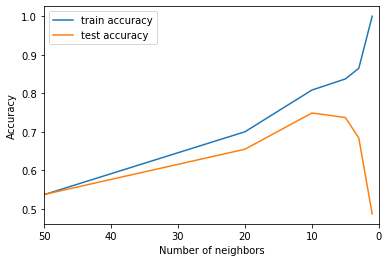

In [6]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_scores.mean(axis=1), label="train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis=1), label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
plt.xlim([50, 0])
plt.legend(loc="best");

<div class="alert alert-warning">
    Note that many neighbors mean a "smooth" or "simple" model, so the plot uses a reverted x axis.
</div>

If multiple parameters are important, like the parameters ``C`` and ``gamma`` in an ``SVM`` (more about that later), all possible combinations are tried:

In [7]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.005988
C: 0.001000, gamma: 0.010000, average score: -0.080428
C: 0.001000, gamma: 0.100000, average score: -0.019658
C: 0.001000, gamma: 1.000000, average score: -0.044587
C: 0.010000, gamma: 0.001000, average score: -0.067557
C: 0.010000, gamma: 0.010000, average score: -0.050715
C: 0.010000, gamma: 0.100000, average score: 0.009718
C: 0.010000, gamma: 1.000000, average score: -0.015597
C: 0.100000, gamma: 0.001000, average score: -0.089669
C: 0.100000, gamma: 0.010000, average score: 0.147290
C: 0.100000, gamma: 0.100000, average score: 0.508387
C: 0.100000, gamma: 1.000000, average score: 0.502442
C: 1.000000, gamma: 0.001000, average score: 0.197964
C: 1.000000, gamma: 0.010000, average score: 0.593140
C: 1.000000, gamma: 0.100000, average score: 0.629293
C: 1.000000, gamma: 1.000000, average score: 0.706674
C: 10.000000, gamma: 0.001000, average score: 0.558625
C: 10.000000, gamma: 0.010000, average score: 0.634464
C: 10.000000, gamm

As this is such a very common pattern, there is a built-in class for this in scikit-learn, ``GridSearchCV``. ``GridSearchCV`` takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

To inspect training score on the different folds, the parameter ``return_train_score`` is set to ``True``.

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3, return_train_score=True, n_jobs = -1)

# n_jobs = -1) do the grid search in parallel

One of the great things about GridSearchCV is that it is a *meta-estimator*. It takes an estimator like SVR above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor.
So we can call ``fit`` on it, to train it:

In [11]:
grid.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=3)

What ``fit`` does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination.
Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use ``predict`` or ``score``:


In [12]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64

You can inspect the best parameters found by ``GridSearchCV`` in the ``best_params_`` attribute, and the best score in the ``best_score_`` attribute:

In [13]:
print(grid.best_score_)

0.7422680758335984


In [14]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


But you can investigate the performance and much more for each set of parameter values by accessing the `cv_results_` attributes. The `cv_results_` attribute is a dictionary where each key is a string and each value is array. It can therefore be used to make a pandas DataFrame.

In [15]:
type(grid.cv_results_)

dict

In [16]:
print(grid.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [17]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001306,0.000043,0.001170,0.000023,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.006906,-0.151779,-0.059555,...,-0.083365,0.072167,20,-0.001629,-0.007875,0.000267,-0.002341,0.000282,-0.002259,0.002993
1,0.001186,0.000075,0.001537,0.000498,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.004390,-0.148643,-0.056922,...,-0.080611,0.071976,19,0.000635,-0.005399,0.002762,-0.000008,0.002721,0.000142,0.002983
2,0.001424,0.000528,0.001330,0.000428,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.006453,-0.135150,-0.046389,...,-0.068952,0.070935,16,0.010832,0.004821,0.014088,0.010056,0.013507,0.010661,0.003297
3,0.001407,0.000750,0.001076,0.000203,0.001,1,"{'C': 0.001, 'gamma': 1}",0.004755,-0.138332,-0.048042,...,-0.070984,0.071069,17,0.009713,0.002878,0.012927,0.008912,0.012464,0.009379,0.003597
4,0.000994,0.000171,0.000992,0.000187,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.004131,-0.148318,-0.056645,...,-0.080328,0.071963,18,0.000859,-0.005125,0.003006,0.000224,0.002955,0.000384,0.002969


In [18]:
cv_results_tiny = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
19,10,1,0.742268
15,1,1,0.701670
14,1,0.1,0.650180
18,10,0.1,0.648874
17,10,0.01,0.606527


There is a problem with using this score for evaluation, however. You might be making what is called a **multiple hypothesis testing error**. If you try very many parameter settings, some of them will work better just by chance, and the score that you obtained might not reflect how your model would perform on new unseen data.
Therefore, it is good to split off a separate test-set before performing grid-search. This pattern can be seen as a training-validation-test split, and is common in machine learning:

<img src="figures/grid_search_cross_validation.svg" width="100%">

We can do this very easily by splitting of some test data using ``train_test_split``, training ``GridSearchCV`` on the training set, and applying the ``score`` method to the test set:

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

/home/sidibe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7262035177984737

We can also look at the parameters that were selected:

In [20]:
grid.best_params_

{'C': 10, 'gamma': 1}

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long.
You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

<img src="figures/train_validation_test2.svg" width="100%">

In [21]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............... C=0.001, gamma=0.001, score=-0.027, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ................ C=0.001, gamma=0.01, score=-0.026, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ................. C=0.001, gamma=0.1, score=-0.018, total=   0.0s
[CV] C=0.001, gamma=1 ................................................
[CV] ................... C=0.001, gamma=1, score=-0.018, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................ C=0.01, gamma=0.001, score=-0.025, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ................. C=0.01, gamma=0.01, score=-0.008, total=   0.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


0.7262035177984737

This is much faster, but might result in worse hyperparameters and therefore worse results.

In [22]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/home/sidibe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7262035177984737

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Apply grid-search to find the best setting for the number of neighbors in ``KNeighborsClassifier``, and apply it to the digits dataset.
      </li>
    </ul>
</div>

In [30]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier

digits = load_digits()
X, y = digits.data, digits.target
param_grid = {'n_neighbors': [1,2,3,5,10,20]}

cv = KFold(n_splits=10, shuffle=True)

X_train,X_test,y_train, y_test = train_test_split(X, y)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

# ...

0.9888888888888889

In [31]:
grid.best_params_

{'n_neighbors': 1}

## Guided hyper-optimization

Hyper-optimization of parameters was done up to now by giving some values to be tried. Usually, we could automatically generated those values (randomly or not) by using `RandomSearchCV` or `GridSearchCV`.

We could do a little be better by trying some parameters which we could consider more probable to optimize our problem depending on the previous parameters which we used before.

We will use `scikit-optimize` and `optuna` to do so. We will use the small Boston regression
dataset to limit the computation time.

In [32]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y
)

n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(
    n_estimators=50, random_state=0
)

In [33]:
reg.fit(X_train, y_train).score(X_test, y_test)

0.888779194505658

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:

param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 8]}
grid = GridSearchCV(reg, param_grid=param_grid, cv=3)

In [36]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=50,
                                                 n_iter_no_change=None,
                 

In [40]:
import pandas as pd
pd.DataFrame(grid.cv_results_).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032928,0.003860,0.001006,0.000049,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.865996,0.879540,0.879969,0.875144,0.006496,3
1,0.077917,0.044344,0.000967,0.000059,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.872447,0.881418,0.887659,0.880487,0.006249,2
2,0.067231,0.000580,0.001034,0.000031,3,150,"{'max_depth': 3, 'n_estimators': 150}",0.878837,0.880357,0.889757,0.882973,0.004828,1


In [41]:
grid.score(X_test, y_test)

0.8947592012650663

In [42]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 150}

In [46]:
import numpy as np

### Hyperparameter search with scikit-optimize

We will use Gaussian Processes to drive the hyper-parameters optimization. We need to give a range of data to use for each parameter that we want to optimize. In addition, we need to create the objective function which we want to minimize.

In [52]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

/home/sidibe/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Once those steps performed, we need to call the the optimization loop.

In [53]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.8856'

We get the best parameters obtained.

In [54]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=4
- learning_rate=0.216073
- max_features=13
- min_samples_split=100
- min_samples_leaf=1


In addition, we can check the objective function values depending of the number of time we are calling it.

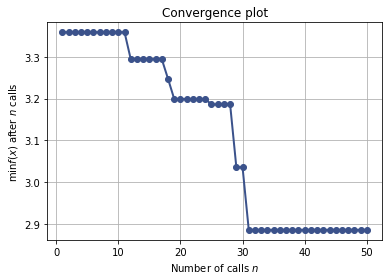

In [55]:
%matplotlib inline
from skopt.plots import plot_convergence

plot_convergence(res_gp);

### Hyperparameter search with Optuna

URL : https://pypi.org/project/optuna/

See video : https://www.youtube.com/watch?v=J_aymk4YXhg

In [49]:
import optuna


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 10**-5, 10**0)
    max_features = trial.suggest_int('max_features', 1, n_features)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)

    reg = GradientBoostingRegressor(
        max_depth=max_depth, n_estimators=50,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

study = optuna.create_study(direction='minimize')
optuna.logging.disable_default_handler()  # limit verbosity
study.optimize(objective, n_trials=100)

# Show best result
print(study.best_trial.params)
print(study.best_trial.value)

{'max_depth': 7, 'learning_rate': 0.2512324626318922, 'max_features': 12, 'min_samples_split': 44, 'min_samples_leaf': 4}
2.895132192360372


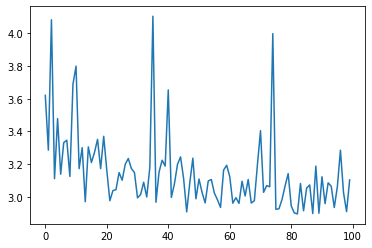

In [56]:
values = [t.value for t in study.trials]
plt.plot(values)

Text(0, 0.5, 'MAE')

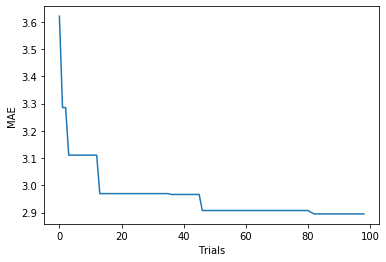

In [57]:
values = [t.value for t in study.trials]
values = [np.min(values[:k]) for k in range(1, len(values))]
plt.plot(values)
plt.xlabel('Trials')
plt.ylabel('MAE')

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Repeat the experiment on the original toy data and try to automatically optimize the parameter `C` and `gamma` of a SVR model.
      </li>
    </ul>
</div>